In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import xgboost as xgb

from sklearn.preprocessing import StandardScaler
# from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
# from tensorflow import keras
# from tensorflow.keras import layers

## DATA EXPLORATION

In [2]:
train_df_org = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df_org = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_df = train_df_org.copy()
test_df = test_df_org.copy()

In [4]:
train_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [5]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
# Checking null counts to fill or discard according to the dtypes and distributions 
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
# Checking dtypes to adjust data by their dtypes (numeric or not)
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

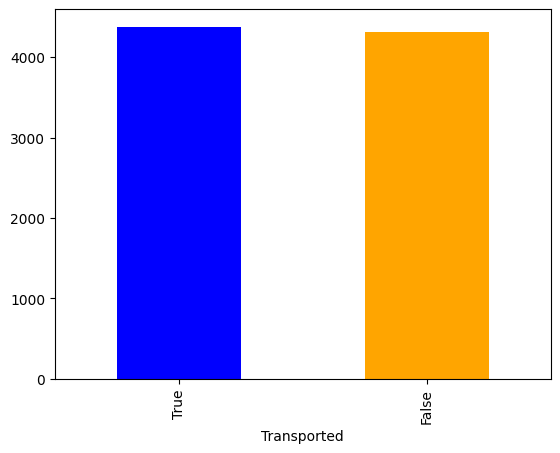

In [8]:
train_df['Transported'].value_counts().plot(kind='bar', color=['blue', 'orange']);

In [9]:
num_columns = [col for col, dtype in train_df.dtypes.items() if dtype == 'float64']
str_columns = [col for col, dtype in train_df.dtypes.items() if dtype == 'object']

print(num_columns) 
print(str_columns)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']


## DATA PREPROCESSING

In [10]:
# The process will continue with functions to apply all operations directly to the test data after all.
def remove_unneccessary_cols(df, col_names_to_remove):
    
    for col in col_names_to_remove:
        if col in df.columns:
            df.drop(col_names_to_remove, axis=1, inplace=True)
            
    return df

Name and PassengerID columns are irrelevant for training.

In [11]:
cols = ['Name', 'PassengerId']
train_df = remove_unneccessary_cols(train_df, cols)

In [12]:
train_df.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

### Numeric Columns Preprocessing

min:0.0 | max: 79.0


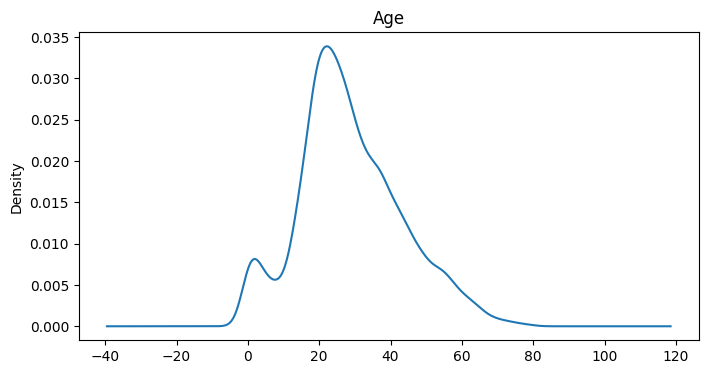

min:0.0 | max: 14327.0


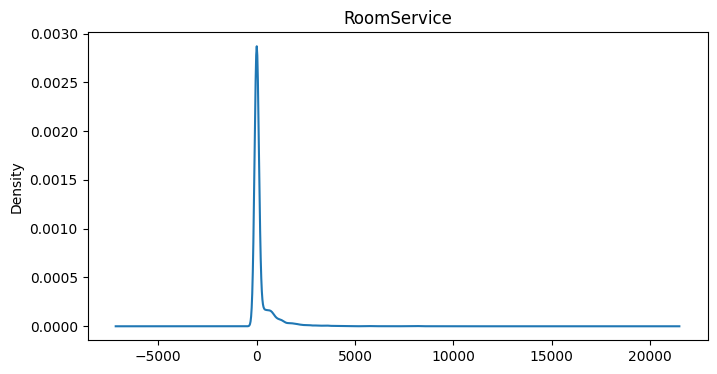

min:0.0 | max: 29813.0


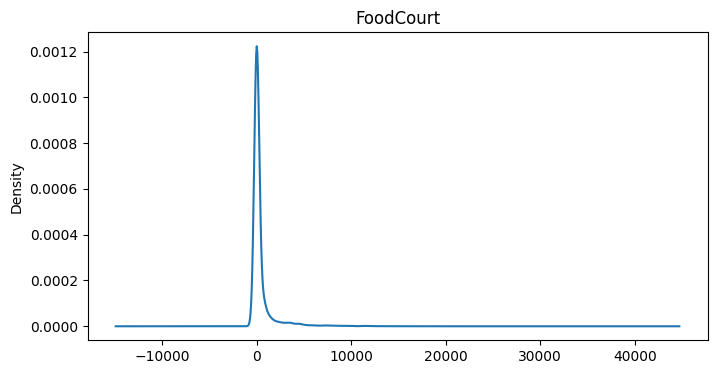

min:0.0 | max: 23492.0


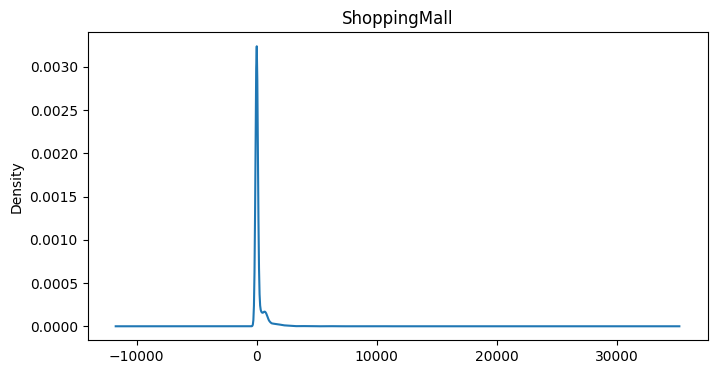

min:0.0 | max: 22408.0


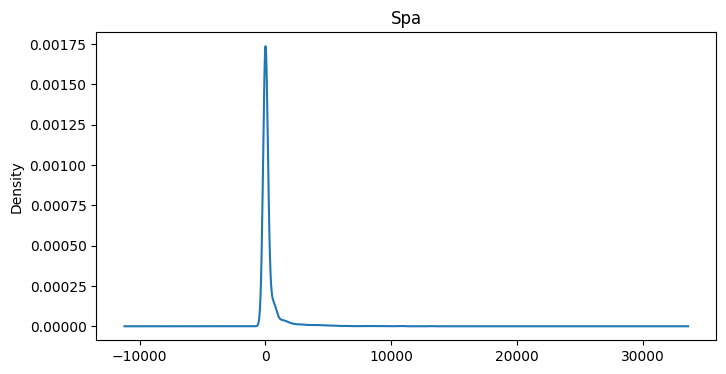

min:0.0 | max: 24133.0


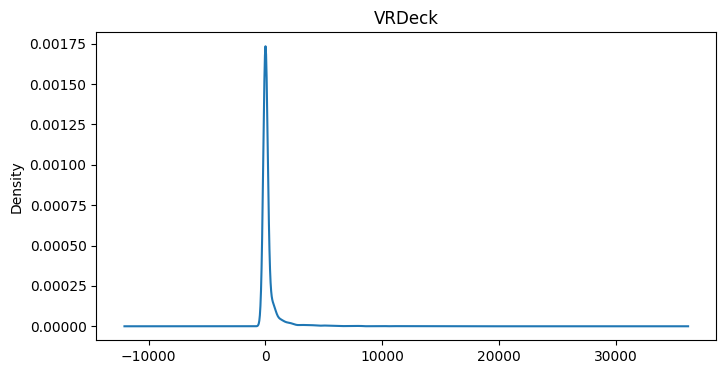

In [13]:
# Checkinge distributions of the numeric columns.
# Bar Chart didn't show anything due to the skewness of the data

for col in num_columns:
    
    min_val = train_df[col].min()
    max_val = train_df[col].max()
    
    plt.figure(figsize=(8, 4))
    plt.title(col)
    plt.ylabel('Count')
    
    print(f"min:{min_val} | max: {max_val}")
    
    train_df[col].plot(kind='kde')

    plt.show()

In [14]:
# We can make the age column categorical.

def make_age_categorical(df):
    
    age_bins = [-1, 18, 30, 45, 60, 100]
    age_labels = ['Child', 'Teen', 'Adult', 'Senior', 'Old']
    df['AgeGroup'] = pd.cut(df.loc[~df['Age'].isna(), 'Age'], bins=age_bins, labels=age_labels)
    # drop the original age column because it is unnecessary anymore
    df.drop('Age', axis=1, inplace=True)
    
    return df


num_columns.remove('Age')
train_df = make_age_categorical(train_df)
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,Adult
1,Earth,False,F/0/S,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,Teen
2,Europa,False,A/0/S,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,Senior
3,Europa,False,A/0/S,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,Adult
4,Earth,False,F/1/S,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,Child


### Anomaly Detection using IQR

When I apply anomaly detection null values are vanishing for a column. So first, I keep the null values in a different variable, then merge it after removing the anomalies. After anomalies are removed, null values can be imputed more accuractely.

In [15]:
def remove_anomalies(df, column_names, multiplier=1.5):
    
    for col in column_names:
        
        null_df = df[df[col].isna()]
        
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)

        IQR = Q3 - Q1

        lower_bound = Q1 - (multiplier * IQR)
        upper_bound = Q3 + (multiplier * IQR)

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        df = pd.concat([df, null_df])
        
    return df

In [16]:
len(train_df)

8693

In [17]:
print(len(train_df)) # check len before removing anomalies to see how many data is removed.
train_df = remove_anomalies(train_df, num_columns)
train_df.head(), len(train_df)

8693


(  HomePlanet CryoSleep  Cabin  Destination    VIP  RoomService  FoodCourt  \
 0     Europa     False  B/0/P  TRAPPIST-1e  False          0.0        0.0   
 1      Earth     False  F/0/S  TRAPPIST-1e  False        109.0        9.0   
 2     Europa     False  A/0/S  TRAPPIST-1e   True         43.0     3576.0   
 3     Europa     False  A/0/S  TRAPPIST-1e  False          0.0     1283.0   
 4      Earth     False  F/1/S  TRAPPIST-1e  False        303.0       70.0   
 
    ShoppingMall     Spa  VRDeck  Transported AgeGroup  
 0           0.0     0.0     0.0        False    Adult  
 1          25.0   549.0    44.0         True     Teen  
 2           0.0  6715.0    49.0        False   Senior  
 3         371.0  3329.0   193.0        False    Adult  
 4         151.0   565.0     2.0         True    Child  ,
 8649)

### Standardizing numerical columns

In [18]:
def standardize_num_columns(df, columns):
    
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    
    return df

In [19]:
num_columns

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [20]:
train_df = standardize_num_columns(train_df, num_columns)

In [21]:
train_df.head()

,HomePlanet,CryoSleep,Cabin,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,AgeGroup
0,Europa,False,B/0/P,TRAPPIST-1e,False,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,False,Adult
1,Earth,False,F/0/S,TRAPPIST-1e,False,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,True,Teen
2,Europa,False,A/0/S,TRAPPIST-1e,True,-0.288114,2.150043,-0.352491,6.527927,-0.232789,False,Senior
3,Europa,False,A/0/S,TRAPPIST-1e,False,-0.359961,0.580400,0.469440,3.088351,-0.093104,False,Adult
4,Earth,False,F/1/S,TRAPPIST-1e,False,0.146315,-0.249943,-0.017958,0.280616,-0.278380,True,Child


### Imputing null values for numeric columns

In [22]:
def impute_numeric_cols(df, columns):
    
    for col in columns:
        
        df[col].fillna(df[col].median(), inplace=True)

    return df

In [23]:
train_df = impute_numeric_cols(train_df, num_columns)

In [24]:
train_df.isna().sum()

HomePlanet      200
CryoSleep       216
Cabin           197
Destination     181
VIP             202
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
AgeGroup        179
dtype: int64

## Categorical Columns Preprocessing

In [25]:
str_columns.append('AgeGroup')
str_columns.remove('PassengerId')
str_columns.remove('Name')

str_columns

['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'AgeGroup']

In [26]:
train_df[str_columns].nunique()

HomePlanet        3
CryoSleep         2
Cabin          6540
Destination       3
VIP               2
AgeGroup          5
dtype: int64

### VIP and CyroSleep columns are mapped to 0 and 1

In [27]:
# VIP and CyroSleep columns are true or false values. So we can convert them as 0 and 1 using mapping easily.

def map_vip_and_cryosleep(df):
    
    mapping = {False: 0., True:1.}
    df['VIP'] = df['VIP'].map(mapping)
    df['CryoSleep'] = df['CryoSleep'].map(mapping)
    
    return df

In [28]:
train_df = map_vip_and_cryosleep(train_df)

In [29]:
print(train_df['VIP'].value_counts())
print(train_df['CryoSleep'].value_counts())

VIP
0.0    8253
1.0     194
Name: count, dtype: int64
CryoSleep
0.0    5396
1.0    3037
Name: count, dtype: int64


### Cabin Column

In [30]:
# cabin column is splitted 3 by `/` as deck, num and side as indicated in Data part of the Competition

def split_cabin(df):
    
    df[['deck','num', 'side']] = df['Cabin'].str.split('/',expand=True)
    df['num'] = df['num'].astype(float)
    df.drop('Cabin', axis=1, inplace=True)
    return df

In [31]:
train_df = split_cabin(train_df)

In [32]:
train_df[['deck', 'num', 'side']].nunique() # checking unique values for deck, num  and side

deck       8
num     1816
side       2
dtype: int64

### One-Hot Encoding

In [33]:
def one_hot_encode_columns(df, columns):
    
    for column in columns:
        
        df_encoded = pd.get_dummies(df[column], prefix=column)
        df.drop(columns=[column], inplace=True)
        df = pd.concat([df, df_encoded], axis=1)

    return df

In [34]:
train_df = one_hot_encode_columns(train_df, ['HomePlanet', 'Destination', 'AgeGroup', 'deck'])
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,num,side,...,AgeGroup_Senior,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,False,0.0,P,...,False,False,False,True,False,False,False,False,False,False
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,True,0.0,S,...,False,False,False,False,False,False,False,True,False,False
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,False,0.0,S,...,True,False,True,False,False,False,False,False,False,False
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,False,0.0,S,...,False,False,True,False,False,False,False,False,False,False
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,True,1.0,S,...,False,False,False,False,False,False,False,True,False,False


### Encoding `deck`, `num` and `side`

In [35]:
def map_side_column(df):
    
    side_mapping = {'P':0., 'S':1.}
    df['side'] = df['side'].map(side_mapping)    
    return df

In [36]:
train_df = map_side_column(train_df)

Num variable goes from 0 to 1800. It determines the passenger's region of the ship in a roughly and in my opinion.
So I decide to group the column.

In [37]:
def categorize_num_column(df):

    bins = [0, 600, 1200, 1801]
    labels = [0, 1, 2]

    df['num_label'] = pd.cut(df['num'], bins=bins, labels=labels, include_lowest=True)
    df.drop('num', axis=1, inplace=True)
    
    return df

In [38]:
train_df = categorize_num_column(train_df)

In [39]:
train_df.replace({True:1., False:0.}, inplace=True)

In [40]:
train_df.dtypes

CryoSleep                     float64
VIP                           float64
RoomService                   float64
FoodCourt                     float64
ShoppingMall                  float64
Spa                           float64
VRDeck                        float64
Transported                   float64
side                          float64
HomePlanet_Earth              float64
HomePlanet_Europa             float64
HomePlanet_Mars               float64
Destination_55 Cancri e       float64
Destination_PSO J318.5-22     float64
Destination_TRAPPIST-1e       float64
AgeGroup_Child                float64
AgeGroup_Teen                 float64
AgeGroup_Adult                float64
AgeGroup_Senior               float64
AgeGroup_Old                  float64
deck_A                        float64
deck_B                        float64
deck_C                        float64
deck_D                        float64
deck_E                        float64
deck_F                        float64
deck_G      

In [41]:
train_df['Transported'] = train_df['Transported'].astype(int)
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,side,HomePlanet_Earth,...,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,num_label
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [42]:
train_df['CryoSleep'].value_counts()

CryoSleep
0.0    5396
1.0    3037
Name: count, dtype: int64

### VIP
Most of the passengers are not VIP likely. So filling with 0s seems okey to me.

In [43]:
train_df['VIP'].fillna(0, inplace=True)

### Rest of the categorical columns are filled with most frequent.

In [44]:
def fill_most_freq(df, cols):
    
    for col in df.columns:
        
        val = df[col].mode()[0]
        df[col].fillna(val, inplace=True)
        
    return df

In [45]:
columns_with_nan = ['CryoSleep', 'side', 'num_label']
train_df = fill_most_freq(train_df, columns_with_nan)

In [46]:
train_df.dropna()
train_df.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,side,HomePlanet_Earth,...,AgeGroup_Old,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,num_label
0,0.0,0.0,-0.359961,-0.297860,-0.352491,-0.293324,-0.280320,0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,-0.177836,-0.291700,-0.297105,0.264363,-0.237639,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,0.0,1.0,-0.288114,2.150043,-0.352491,6.527927,-0.232789,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,-0.359961,0.580400,0.469440,3.088351,-0.093104,0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.146315,-0.249943,-0.017958,0.280616,-0.278380,1,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


## TRAINING

### Trying Neural Nets

In [47]:
train_df['num_label'] = train_df['num_label'].astype(float)
X = train_df.drop('Transported', axis=1)
y = train_df['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:

import torch
import torch.nn as nn
import torch.optim as optim

In [49]:
class SimpleBinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(SimpleBinaryClassifier, self).__init__()
        self.input_size = input_size
        
#         self.layer1 = nn.Linear(input_size, 60)
#         self.act1 = nn.ReLU()
#         self.layer2 = nn.Linear(60, 60)
#         self.act2 = nn.ReLU()
#         self.layer3 = nn.Linear(60, 60)
#         self.act3 = nn.ReLU()
#         self.output = nn.Linear(60, 1)
#         self.sigmoid = nn.Sigmoid()
        
        # Define the layers
        self.hidden_layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Sigmoid activation for binary classification
       
        )

    def forward(self, x):
#         x = self.act1(self.layer1(x))
#         x = self.act2(self.layer2(x))
#         x = self.act3(self.layer3(x))
#         x = self.sigmoid(self.output(x))
#         return x
        x = self.hidden_layers(x)  # Apply sigmoid activation for binary classification
        return x

In [50]:
model = SimpleBinaryClassifier(X_train.shape[1])
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust optimizer and learning rate
num_epochs = 1500



In [51]:
for epoch in range(num_epochs):
    model.train()  # Set the model in training mode
    optimizer.zero_grad()  # Zero the gradient buffers

    # Forward pass
    outputs = model(torch.tensor(X_train.values, dtype=torch.float32))
#     print(outputs>1)
#     print()
    loss = criterion(outputs, torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1))

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')



Epoch [1/1500], Loss: 0.6939036846160889
Epoch [11/1500], Loss: 0.6925355195999146
Epoch [21/1500], Loss: 0.6910539865493774
Epoch [31/1500], Loss: 0.6893364787101746
Epoch [41/1500], Loss: 0.6871597170829773
Epoch [51/1500], Loss: 0.6843186616897583
Epoch [61/1500], Loss: 0.6805746555328369
Epoch [71/1500], Loss: 0.675538957118988
Epoch [81/1500], Loss: 0.668795108795166
Epoch [91/1500], Loss: 0.6601237058639526
Epoch [101/1500], Loss: 0.6495993137359619
Epoch [111/1500], Loss: 0.6372719407081604
Epoch [121/1500], Loss: 0.6231346726417542
Epoch [131/1500], Loss: 0.6072566509246826
Epoch [141/1500], Loss: 0.5897433161735535
Epoch [151/1500], Loss: 0.5708882808685303
Epoch [161/1500], Loss: 0.5512111186981201
Epoch [171/1500], Loss: 0.5313317775726318
Epoch [181/1500], Loss: 0.5118563771247864
Epoch [191/1500], Loss: 0.49430611729621887
Epoch [201/1500], Loss: 0.4793141782283783
Epoch [211/1500], Loss: 0.46693772077560425
Epoch [221/1500], Loss: 0.45685967803001404
Epoch [231/1500], Los

In [52]:
model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    val_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
    
    # Clamp the validation output to be between 0 and 1
    val_outputs = torch.clamp(val_outputs, 0, 1)
    
    val_loss = criterion(val_outputs, torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1))

print(f'Validation Loss: {val_loss.item()}')


Validation Loss: 0.48878711462020874


In [53]:
from sklearn.metrics import accuracy_score

In [54]:
# Define a prediction threshold (e.g., 0.5 for a binary classification threshold)
threshold = 0.5

# Make predictions on the test data
model.eval()  # Set the model in evaluation mode
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test.values, dtype=torch.float32))
    # Apply the threshold to convert probabilities to binary predictions
    test_predictions = (test_outputs >= threshold).float()

# Calculate accuracy
accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')

Accuracy on Test Data: 78.03%


## TEST SET PREDICTION